# Hypothesis testing for number of mixture components
http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#example-mixture-plot-gmm-selection-py

In [1]:
import itertools
import csv
import numpy as np
from scipy import linalg
from scipy.stats import cumfreq
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import mixture
%matplotlib inline
np.random.seed(1)

## Load data, downsample, and keep only first 96 features

In [2]:
with open('/Users/Tyler/Google Drive/DataScience/synapse_features_z-score.csv','r') as csvfile:
    reader = csv.reader(csvfile)
    X = np.array([[float(e) for e in r] for r in reader])


# Keep only first 96 features
X = X[np.random.choice(range(X.shape[0]),size=100000,replace=False),0:24*4]
#X = X[:,0:24*4]
print 'data loaded'

data loaded


## Perform model selection using BIC to find the most likely number of mixture components $\hat{k}$

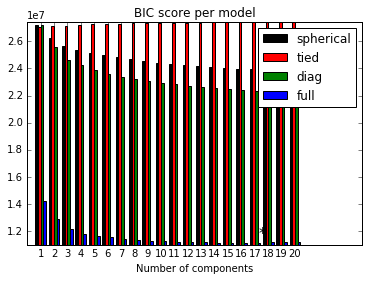

In [3]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 21)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GMM(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'g', 'b', 'c', 'm', 'y'])
clf = best_gmm
bars = []

# Plot the BIC scores
spl = plt.subplot(1, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)
plt.show()

## Statistical inference

### Step 1: Define model and assumptions

$\vec{X} ~ f_{\vec{X}} \in {F_{\vec{X}}(\cdot;\theta): \theta \in \Theta}$

We assume $f$ is a GMM and $\theta = [\bf{\mu}, \bf{\Sigma}, \vec{\pi}, k]$, where k is the number of mixture components and $\vec{\pi}$ are the mixing weights of each mixture component.

### Step 2: Formalize test

$H_0: k = k_0$

$H_1: k = k_1$

### Step 3: Describe the test statistic

$\Lambda = \frac{L(\theta_1;X)}{L(\theta_0;X)}$

In [5]:
# hypothesis testing for testing:
# k0 # of mixture components vs k1 # mixture components
def gmm_test(X,k0,k1,nboot):
    nsample = X.shape[0]

    gmm0 = mixture.GMM(n_components=k0, covariance_type='full')
    gmm0.fit(X)
    L0 = sum(gmm0.score(X))
    gmm1 = mixture.GMM(n_components=k1, covariance_type='full')
    gmm1.fit(X)
    L1 = sum(gmm1.score(X))
    LRstat = -2*(L1 - L0)

    LRstat0 = []

    for i in range(nboot):
        Xboot = gmm0.sample(n_samples=nsample)
        gmm0_boot = mixture.GMM(n_components=k0, covariance_type = 'full')
        gmm0_boot.fit(Xboot)
        L0_boot = sum(gmm0_boot.score(Xboot))
        gmm1_boot = mixture.GMM(n_components=k1, covariance_type = 'full')
        gmm1_boot.fit(Xboot)
        L1_boot = sum(gmm1_boot.score(Xboot))
        LRstat0.append(-2*(L1_boot - L0_boot))

    ecdf, lowlim, binsize, extrapoints = cumfreq(LRstat0)
    ecdf = ecdf/len(LRstat0)

    bin = np.mean([lowlim,lowlim+binsize])
    bins = []

    for i in range(len(ecdf)):
        bins.append(bin)
        bin = bin + binsize
    
    if min(bins) > LRstat:
        p = 0
    else:
        p = max(ecdf[bins<=LRstat])

    return p

### Step 4a: Sample from the null

In [6]:
alpha = 0.05

k0 = 1
k1 = 3
nboot = 100
n_samples = np.array(range(1,101,5))*10
n_iterations = 100

pow_null = np.array((), dtype=np.dtype('float64'))

gmm0 = mixture.GMM(n_components=k0, covariance_type='full')
gmm0.means_ = np.array([[0]])
gmm0.covars_ = np.array([[[1]]])
gmm0.weights_ = np.array([1])
for n in n_samples:
    p = np.array((), dtype=np.dtype('float64'))
    
    for i in range(n_iterations):
        X0 = gmm0.sample(n)
        p = np.append(p,gmm_test(X0,k0,k1,nboot))
        
    pow_null = np.append(pow_null, np.sum(1.0*(p < alpha))/n_iterations)
    
print 'finished sampling from null'

finished sampling from null


### Step 4b: Sample from the alternative

In [9]:
pow_alt = np.array((), dtype=np.dtype('float64'))

gmm1 = mixture.GMM(n_components=k1, covariance_type='full')
gmm1.means_ = np.array([[-2],[0],[2]])
gmm1.covars_ = np.array([[[1]],[[1]],[[1]]])
gmm1.weights_ = np.array([.4, .2, .4])

for n in n_samples:
    p = np.array((), dtype=np.dtype('float64'))
    
    for i in range(n_iterations):
        X1 = gmm1.sample(n)
        p = np.append(p,gmm_test(X1,k0,k1,nboot))
        
    pow_alt = np.append(pow_alt, np.sum(1.0*(p < alpha))/n_iterations)
    
print 'finished sampling from alternative'

finished sampling from alternative


### Step 5: Plot power vs n

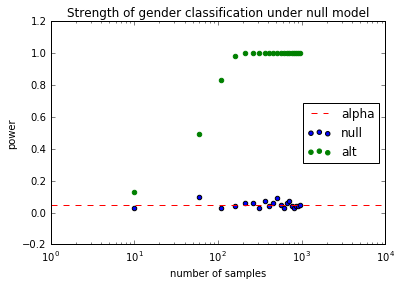

In [10]:
plt.scatter(n_samples, pow_null, hold=True, label='null')
plt.scatter(n_samples, pow_alt, color='green', hold=True, label='alt')
plt.xscale('log')
plt.xlabel('number of samples')
plt.ylabel('power')
plt.title('Strength of gender classification under null model')
plt.axhline(alpha, color='red', linestyle='--', label='alpha')
plt.legend(loc=5)
plt.show()

### Step 6: Apply test to actual data

In [6]:
k0 = 1
k1 = 17
nboot = 100

p = gmm_test(X,k0,k1,nboot)

print p

0
